In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), mismatched flags (18))


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 25, use_cuda = true)

Args(0.003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

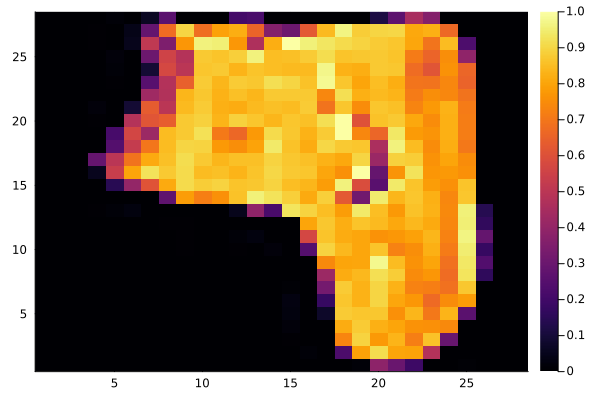

In [15]:
heatmap(x0[:,:,1])

# Test conventional network

In [42]:
construct_model = n -> Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            Dense(28^2 => n, relu),
            Dense(n => 10),
            softmax)

#31 (generic function with 1 method)

In [43]:
model = construct_model(128)

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = Dense(784 => 128, relu),  # 100_480 parameters
    layer_4 = Dense(128 => 10),         # 1_290 parameters
    layer_5 = WrappedFunction(softmax),
)         # Total: 103_338 parameters,
          #        plus 0 states.

In [17]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = (weight = Float32[-0.0112625575 0.09778222 … -0.10101536 0.090369396; -0.080769345 0.06662725 … 0.0866409 -0.091435656; … ; 0.088066004 -0.111865155 … -0.014957014 -0.092328005; 0.049049195 -0.076358505 … 0.005965299 0.0023016678], bias = Float32[0.022867223, -0.005552969, 0.0128062535, 0.016987672, -0.029769417, -0.028511818, -0.034402616, -0.012781019, 0.005802878, 0.033536788  …  0.025755508, 0.0049556494, 0.01800868, -0.015800416, 0.009187677, 0.0042766673, 0.011223478, 0.0118460525, 0.019908717, -0.0135502685]), layer_4 = (weight = Float32[0.113127045 -0.04885875 … -0.03762582 0.08072976; 0.016276116 -0.043997686 … 0.0995841 0.017578097; … ; -0.09091437 -0.020437691 … -0.024808904 0.018207107; 0.0711904 -0.122683704 … -0.13283393 -0.019145327], bias = Float32[-0.031575713, -0.087607525, -0.0455442, 0.051857945, 0.047413476, 0.079458684, 0.08564899, -

In [18]:
yp, _ = model(x0, ps, st);

In [19]:
yp |> size

(10, 128)

In [20]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [21]:
loss_function(x0, y0, model, ps, st)

2.864157f0

In [22]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[2.864157f0, 1.9233735f0, 1.2968891f0, 1.1170568f0, 1.0270884f0, 0.63690287f0, 0.92879707f0, 0.9124346f0, 0.92119944f0, 0.9705627f0  …  0.11594656f0, 0.15101837f0, 0.10700473f0, 0.18064329f0, 0.082851544f0, 0.12807271f0, 0.2724829f0, 0.20006412f0, 0.081470765f0, 0.07322279f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.46144903; 0.16183382; … ; 0.3422541; 0.40121827;;], scale = Float32[0.5543774; 0.83038914; … ; 0.84365195; 0.58893675;;]), layer_3 = (weight = Float32[0.20034973 0.53690016 … 0.52623254 0.4368058; 0.41211313 0.8249792 … 0.8331705 0.35543883; … ; 0.33141673 0.07593279 … 0.09021832 0.057576112; 0.103304416 0.023922317 … 0.18768586 0.12458693], bias = Float32[-0.43707567, -0.86873966, -0.96514493, 0.013967831, -0.2687735, -0.43152562, -0.20269972, -0.069322586, -0.09408635, -0.037173938  …  -0.45184082, 0.039936, -0.38106498, -0.08906972, -0.14077392, -0.113865666, -0.25477007, -0.44944635, -0.16831279, -0.08903752]), layer_4 = (weight = Float32[-0.24182308 -0

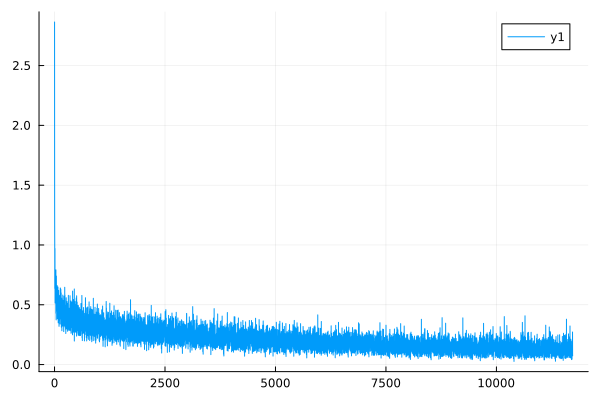

In [23]:
plot(losses)

In [24]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [25]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [26]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.0821

In [27]:
test(model, test_loader, pst, stt)

0.8737

In [ ]:
function automate_train(n::Integer, e::Integer)
    args = Args(batchsize = 128, epochs = e, use_cuda = true)
    model = construct_model(n)
    ps, st = Lux.setup(args.rng, model)
    losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)
    final_loss = losses[end]
    accuracy = test(model, test_loader, pst, stt)

    return accuracy, final_loss
end

automate_train (generic function with 1 method)

In [47]:
automate_train(64, 5)

[ Info: Training on CUDA GPU


(0.8683, 0.2562503f0)

In [ ]:
exprautomate_train(64, 5)

[ Info: Training on CUDA GPU


(0.8683, 0.2562503f0)

# Test Phasor network

In [28]:
import .PhasorNetworks: default_bias

In [29]:
p_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 10, soft_angle, init_bias=default_bias),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#25),
    layer_4 = WrappedFunction(#26),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),      # 20 parameters
    ),
)         # Total: 103_476 parameters,
          #        plus 0 states.

In [30]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.053419817 -0.023526829 … 0.0057635712 0.031198414; -0.04953098 -0.012112024 … -0.05046695 -0.04445622; … ; -0.061836384 -0.011735573 … 0.038857743 -0.007830564; 0.03390087 0.03546983 … 0.024223208 -0.014435542],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[-0.097034946 0.14052758 … -0.1211014 -0.058010712; 0.04700722 -0.01674184 … 0.07477759 0.09891199; … ; 0.047453657 0.09923677 … -0.038886756 -0.12842159; 0.07829463 0.046608783 … -0.15043433 -0.06946478],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [31]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[-0.097013436 -0.23029286 … 0.186224 0.30835798; -0.18280932 0.062673174 … -0.2511161 -0.063191555; … ; 0.054487865 -0.013524863 … -0.010329804 -0.036784258; 0.16722052 0.05371407 … -0.09775025 0.13016252], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = NamedTuple(), bias = NamedTuple()), layer_6 = (dense = NamedTuple(), bias = NamedTuple())))

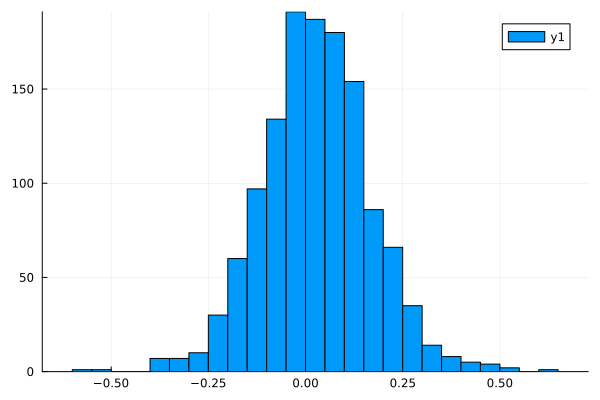

In [32]:
histogram(cdev(vec(yp0)))

In [33]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = quadrature_loss(y_pred, y_onehot) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [34]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

0.18832983f0

In [35]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CUDA GPU


(Any[0.18832985f0, 0.23266286f0, 0.16480953f0, 0.12653269f0, 0.09437427f0, 0.092776164f0, 0.07870093f0, 0.08119163f0, 0.083989106f0, 0.08176201f0  …  0.014439989f0, 0.012626068f0, 0.010037439f0, 0.01890427f0, 0.0149892615f0, 0.0152587425f0, 0.017467996f0, 0.018342396f0, 0.01003704f0, 0.014512447f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[-0.0002058763; -0.41275188; … ; 0.017973108; -0.8279096;;], scale = Float32[0.8335568; 0.99152684; … ; 0.83092475; 1.3226389;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.46227905 0.12847807 … 0.35681054 0.061945587; 0.12228705 -0.9596197 … -0.053692073 -1.4205915; … ; -0.35057738 -0.056420736 … -0.21918753 0.02415982; 0.05228519 -0.21859129 … 0.13783838 -0.29440632],), bias = (bias_real = Float32[1.3149135, 2.1381783, 1.4636415, 0.56252754, 0.9690326, 1.3837997, 1.3548179, 1.5570531, 1.4135787, 0.64982134  …  1.4982721, 1.4308553, 1.2891561, 1.3519217, 1.9645764, 0.90689075, -0.9970062, 1.22975

In [36]:
ps_train_f.layer_5.bias

(bias_real = Float32[1.3149135, 2.1381783, 1.4636415, 0.56252754, 0.9690326, 1.3837997, 1.3548179, 1.5570531, 1.4135787, 0.64982134  …  1.4982721, 1.4308553, 1.2891561, 1.3519217, 1.9645764, 0.90689075, -0.9970062, 1.2297571, 0.85452807, 1.2845056], bias_imag = Float32[-0.6883032, 0.09066872, -0.238938, 0.6526279, 0.37196118, -0.007435704, -0.21446705, -0.13517699, -0.1814351, 0.38692743  …  -0.8532642, -0.024745753, -0.15002422, 0.31112826, 0.09572868, 0.24805205, 0.0071869898, -0.21023773, 0.26169607, 0.01984348])

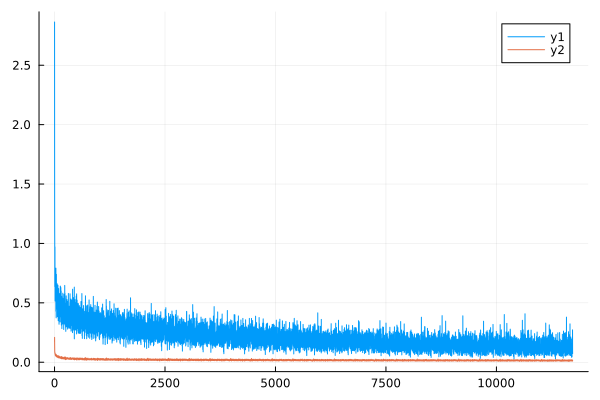

In [37]:
plot(losses)
plot!(log1p.(losses_f))

In [38]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_quadrature(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [39]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.8794

# Test spiking behavior

In [111]:
spk_model = Chain(FlattenLayer(),
                    LayerNorm((28^2,)),
                    x -> tanh.(x), 
                    MakeSpiking(spk_args, repeats),
                    PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
                PhasorDense(128 => 10, soft_angle, init_bias=default_bias),
                )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#39),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),      # 20 parameters
    ),
)         # Total: 103_476 parameters,
          #        plus 0 states.

In [112]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.016899515 -0.046879657 … 0.03581762 -0.056115773; 0.022343645 0.012424866 … 0.056800134 0.0118307145; … ; 0.044310868 -0.04756508 … -0.06107081 -0.003921594; -0.029771093 0.03142143 … -0.05477327 -0.03335695],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[-0.06362014 -0.142713 … -0.01659124 -0.081634015; 0.1364428 0.11065934 … 0.050716996 -0.110785246; … ; 0.021302838 -0.018853288 … 0.007108897 0.09507127; 0.0430668 0.15143494 … -0.11120211 0.022908794],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],

In [ ]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.0001395, 1.9999846, 1.9999315, 2.0000668, 2.0000393, 1.9999925, 2.0000255, 2.0000927, 2.0000372, 2.0000224  …  20.99732, 21.0278, 21.496716, 21.494024, 20.998564, 21.497496, 21.496584, 20.994265, 20.505024, 21.477776], (10, 128), 1280, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), la

In [102]:
ys0.train

SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.0001395, 1.9999846, 1.9999315, 2.0000668, 2.0000393, 1.9999925, 2.0000255, 2.0000927, 2.0000372, 2.0000224  …  20.99732, 21.0278, 21.496716, 21.494024, 20.998564, 21.497496, 21.496584, 20.994265, 20.505024, 21.477776], (10, 128), 1280, 0.5f0)

In [94]:
ys0.t_span

(0.0f0, 20.0f0)

In [97]:
st1 = get_time(ys0.train, (5.0, 10.0))

Spike Train: (10, 128) with 6399 spikes.

In [98]:
st1_b1 = st1[:,1:10]

Spike Train: (10, 10) with 500 spikes.

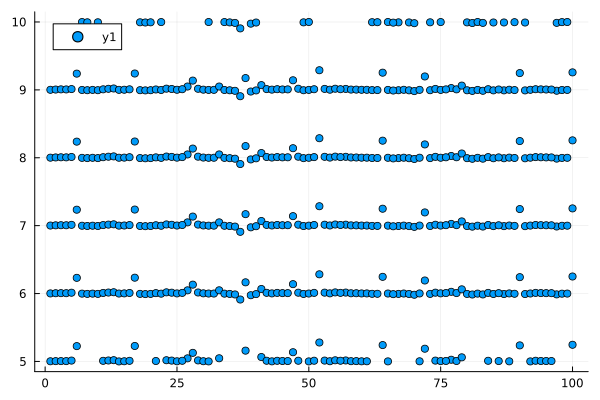

In [ ]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

In [96]:
y_spk_f, st_spk_f = spk_model(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[1.9996153, 2.0201118, 1.9833077, 1.9909195, 1.9784555, 2.0172422, 1.9960722, 2.0042093, 2.0127385, 2.0120473  …  21.49966, 20.99788, 20.51538, 21.001633, 21.159737, 21.029158, 21.008183, 20.998999, 21.054039, 21.493208], (10, 128), 1280, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), la

In [46]:
y_spk_f

SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[1.9996153, 2.0201118, 1.9833077, 1.9909195, 1.9784555, 2.0172422, 1.9960722, 2.0042093, 2.0127385, 2.0120473  …  21.49966, 20.99788, 20.51538, 21.001633, 21.159737, 21.029158, 21.008183, 20.998999, 21.054039, 21.493208], (10, 128), 1280, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0))

In [47]:
y_p_f = train_to_phase(y_spk_f);

In [48]:
size(y_p_f)

(21, 10, 128)

In [125]:
st2 = get_time(y_spk_f.train, (5.5, 6.5))

Spike Train: (10, 128) with 1280 spikes.

In [126]:
st2_b1 = st2[:,1:10]

Spike Train: (10, 10) with 100 spikes.

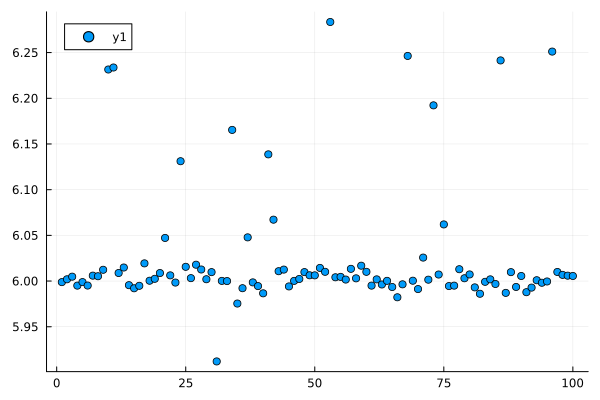

In [127]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

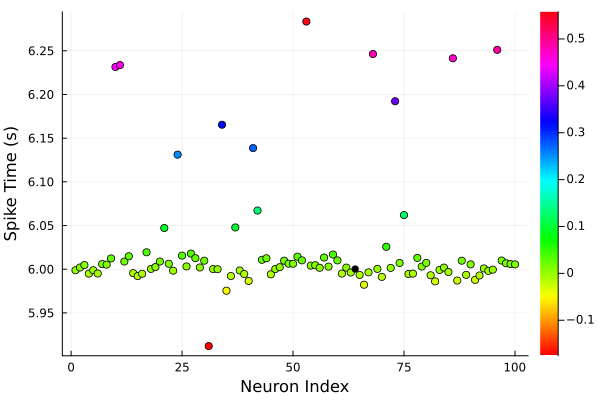

In [141]:
fig = scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times, marker_z=vec(y_p_f[5,:,1:10]), c = :hsv, legend=false, colorbar=true)
xlabel!("Neuron Index")
ylabel!("Spike Time (s)")

In [142]:
png(fig, "../figures/phase_scatter.png")

"../figures/phase_scatter.png"

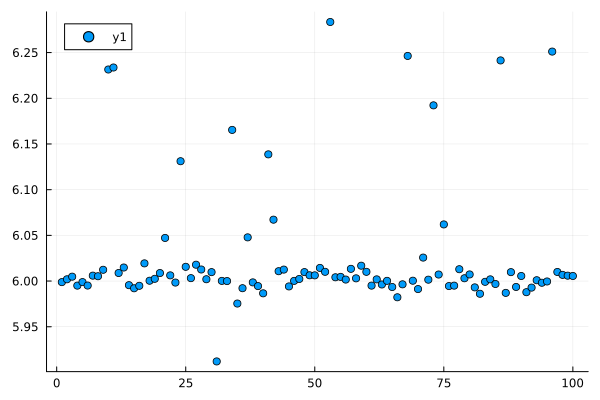

In [ ]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

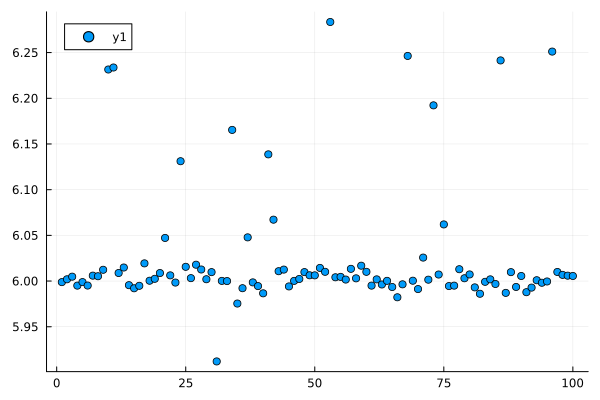

In [ ]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

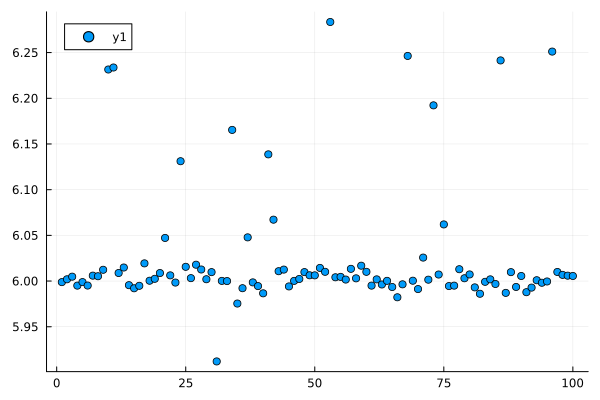

In [ ]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

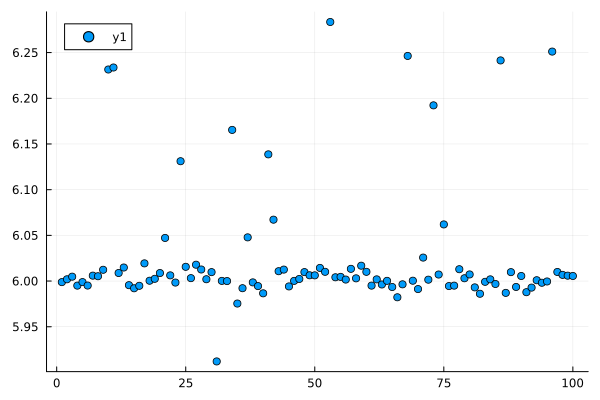

In [ ]:
scatter(LinearIndices(st2_b1.shape)[st2_b1.indices], st2_b1.times) 

In [117]:
spk_inner = Chain(FlattenLayer(),
                    LayerNorm((28^2,)),
                    x -> tanh.(x), 
                    MakeSpiking(spk_args, repeats),
                    PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
                    x -> x,
                )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#45),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_6 = WrappedFunction(#46),
)         # Total: 102_176 parameters,
          #        plus 0 states.

In [118]:
y_spk_i, _ = spk_inner(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(119, 128), CartesianIndex(120, 128), CartesianIndex(121, 128), CartesianIndex(122, 128), CartesianIndex(123, 128), CartesianIndex(124, 128), CartesianIndex(125, 128), CartesianIndex(126, 128), CartesianIndex(127, 128), CartesianIndex(128, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  16375, 16376, 16377, 16378, 16379, 16380, 16381, 16382, 16383, 16384], Float32[1.6158682, 1.8270661, 1.7045143, 1.9811404, 2.0624511, 1.6619648, 1.5321182, 1.8183666, 1.6792314, 1.9924765  …  20.573183, 20.688255, 20.941872, 20.858662, 20.884678, 20.948442, 20.263206, 20.693275, 20.678337, 20.269882], (128, 128), 16384, 0.25f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20

In [119]:
st3 = get_time(y_spk_i.train, (5.0, 10.0))

Spike Train: (128, 128) with 81913 spikes.

In [123]:
st3_b1 = st3[:,1:5]

Spike Train: (128, 5) with 3198 spikes.

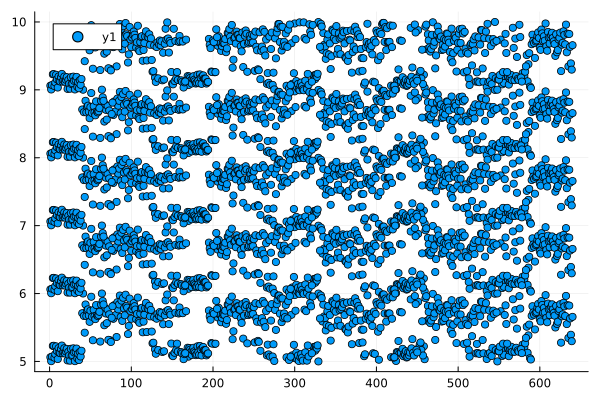

In [124]:
scatter(LinearIndices(st3_b1.shape)[st3_b1.indices], st3_b1.times) 

In [105]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    acc = []
    n_phases = []
    num = 0

    n_batches = length(data_loader)

    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
            y = gdev(1.0f0 .* onehotbatch(y, 0:9))
        end
        
        spk_output, _ = model(x, ps, st)
        ŷ = train_to_phase(spk_output)
        
        append!(acc, sum.(accuracy_quadrature(ŷ, y))) ## Decode the output of the model
        num += size(x)[end]
    end

    acc = sum(reshape(acc, :, n_batches), dims=2) ./ num
    return acc
end

fmnist_spiking_accuracy (generic function with 1 method)

In [106]:
spk_a = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)

21×1 Matrix{Float64}:
 0.1
 0.1756
 0.7414
 0.8288
 0.8527
 0.8641
 0.8702
 0.8734
 0.8752
 0.8767
 0.8786
 0.8781
 0.8783
 0.8786
 0.8801
 0.8795
 0.8808
 0.8803
 0.8806
 0.0802
 0.079

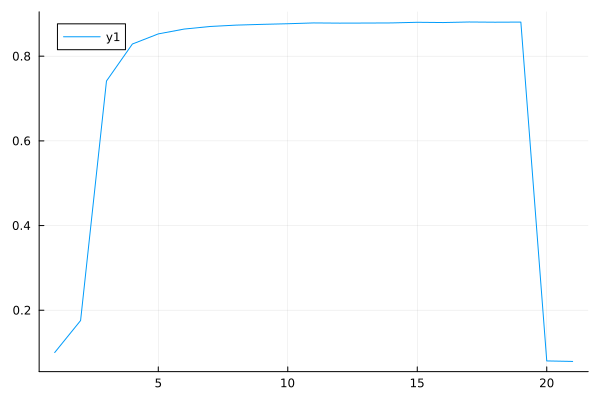

In [107]:
plot(spk_a)